<a href="https://colab.research.google.com/github/Anik-1802021/ML_Autoencoder_Increase_Performance/blob/main/Increase%20PNSR%20v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
train_images=sorted(os.listdir('/content/drive/MyDrive/NORMAL'))

In [48]:
train_image=[]
for im in train_images:
  img=image.load_img('/content/drive/MyDrive/NORMAL/'+im,target_size=(512,512),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [49]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(512,512), cmap='gray')
  plt.show()

In [50]:
# #Adding gaussian noise with 0.05 factor
# def add_noise(image):
#   row,col,ch=image.shape
#   mean=0
#   sigma=1
#   gauss=np.random.normal(mean,sigma,(row,col,ch))
#   gauss=gauss.reshape(row,col,ch)
#   noisy=image+gauss*0.05
#   return noisy

In [53]:
def add_noise(image):
    # Create a copy of the image to avoid modifying the original
    noisy_image = np.copy(image)

    # Get the dimensions of the image
    row, col, ch = image.shape

    # Calculate the number of pixels to be corrupted by noise
    prob = 0.05  # Adjust the probability of noise
    num_salt = np.ceil(prob * image.size * 0.5).astype(int)
    num_pepper = np.ceil(prob * image.size * 0.5).astype(int)

    # Add salt noise (white pixels)
    salt_coords = [np.random.randint(0, i, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1], :] = 255  # Assuming the image is in the 0-255 range

    # Add pepper noise (black pixels)
    pepper_coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy

In [54]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

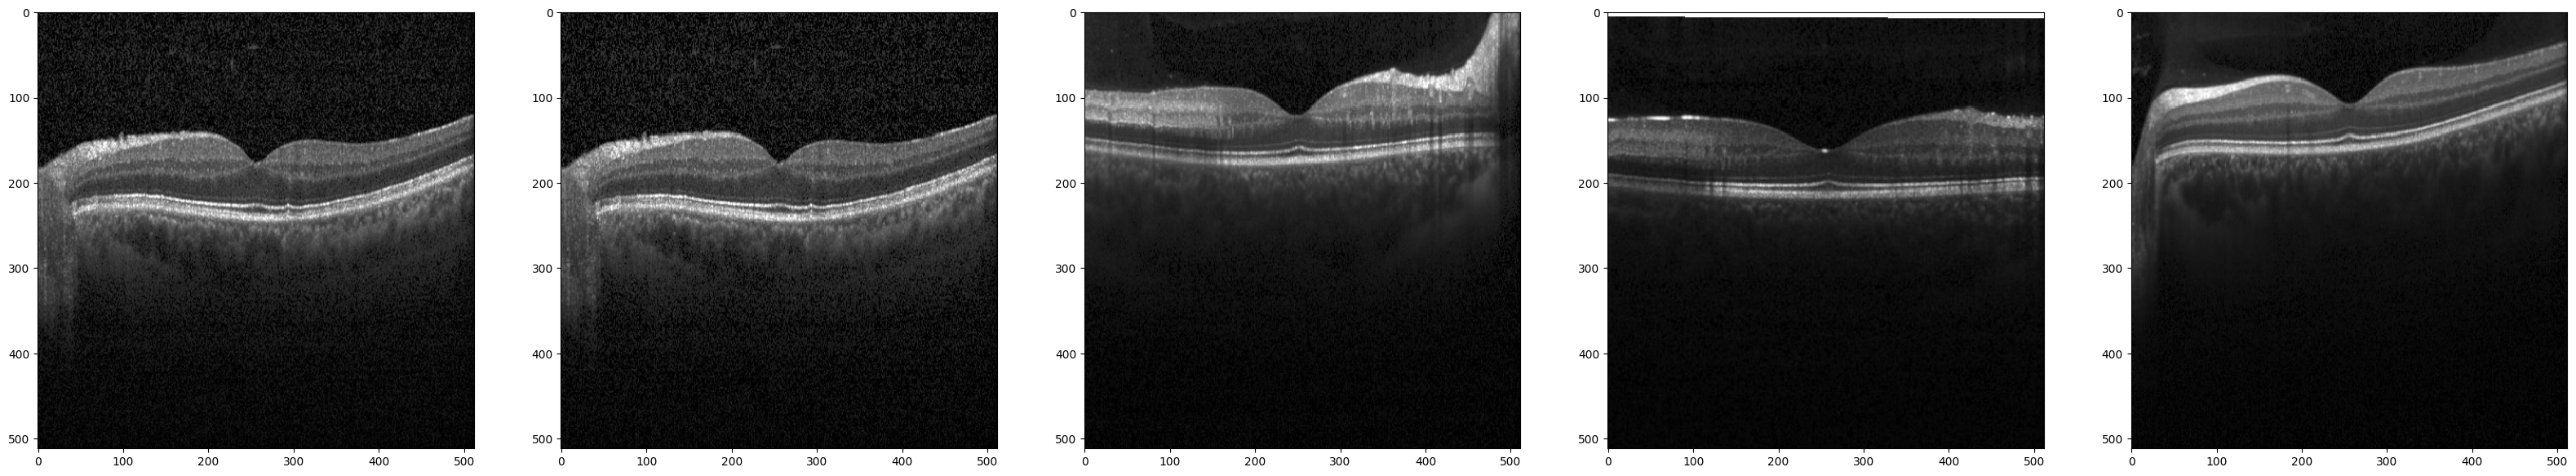

In [55]:
plot_img(train_df)

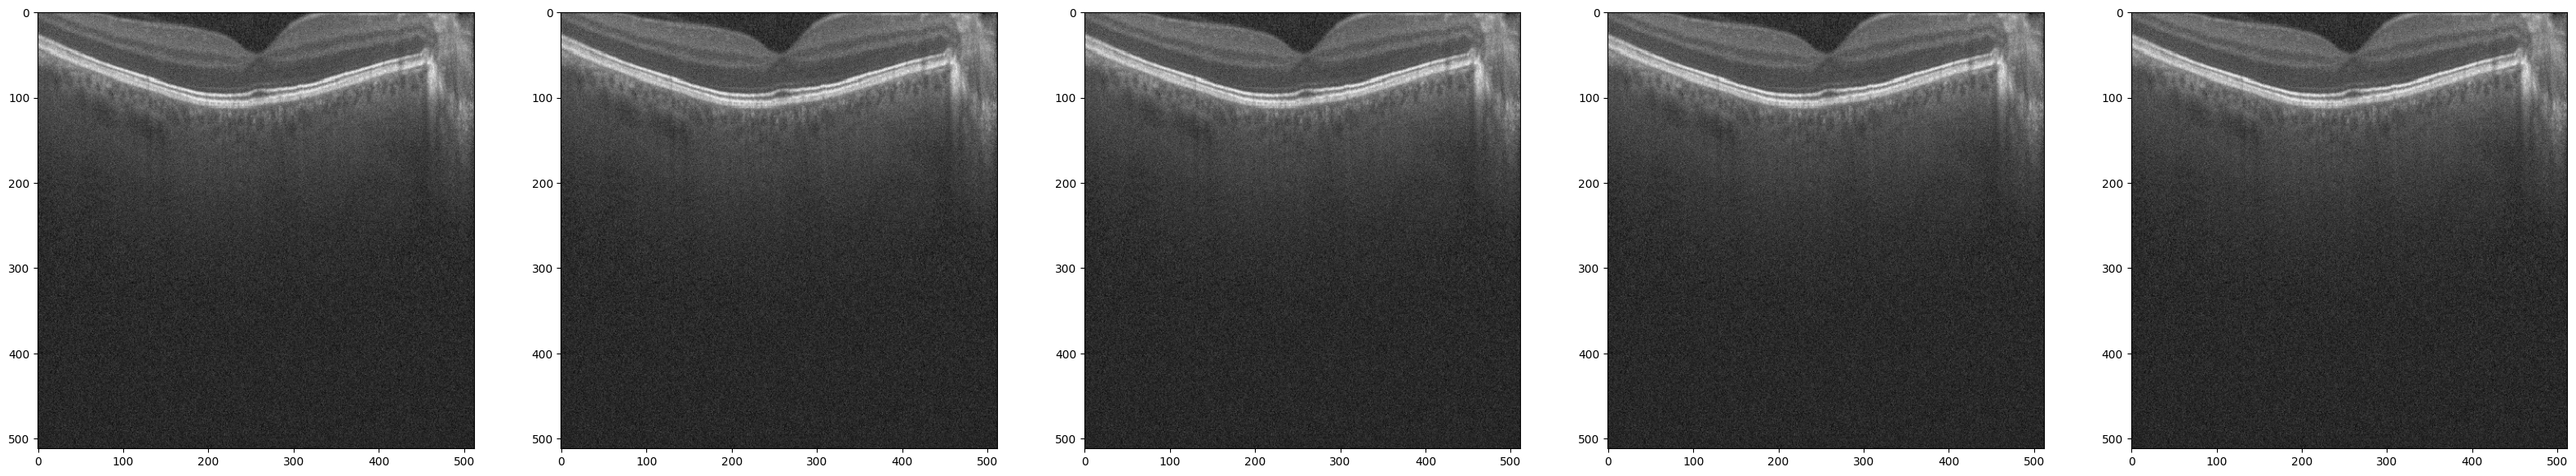

In [56]:
plot_img(noised_df)

In [57]:
original_train=train_df[:400]
original_test=train_df[400:]

noised_train=noised_df[:400]
noised_test=noised_df[400:]

In [58]:
def autoencoder():
  input_img=Input(shape=(512,512,1),name='image_input')
  #enoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  return autoencoder

In [59]:
model= autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 512, 512, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 512, 512, 64)      640       
                                                                 
 pool1 (MaxPooling2D)        (None, 256, 256, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 128, 64)      0         
                                                                 
 Conv3 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 256, 256, 64)      0   

In [60]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(noised_train, original_train, epochs=18, batch_size=3, validation_data=(noised_test, original_test), callbacks=[early_stopping])

Epoch 1/18
134/134 [==============================] - 11s 74ms/step - loss: 0.4690 - val_loss: 0.4403
Epoch 2/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4535 - val_loss: 0.4372
Epoch 3/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4545 - val_loss: 0.4303
Epoch 4/18
134/134 [==============================] - 9s 68ms/step - loss: 0.4524 - val_loss: 0.4350
Epoch 5/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4526 - val_loss: 0.4293
Epoch 6/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4539 - val_loss: 0.4287
Epoch 7/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4511 - val_loss: 0.4286
Epoch 8/18
134/134 [==============================] - 9s 67ms/step - loss: 0.4519 - val_loss: 0.4301
Epoch 9/18
134/134 [==============================] - 9s 66ms/step - loss: 0.4514 - val_loss: 0.4290
Epoch 10/18
134/134 [==============================] - 9s 69ms/step - loss: 0.4500 - val_l

In [61]:
noised_test =noised_df[400:]

1/1 [==============================] - 0s 74ms/step


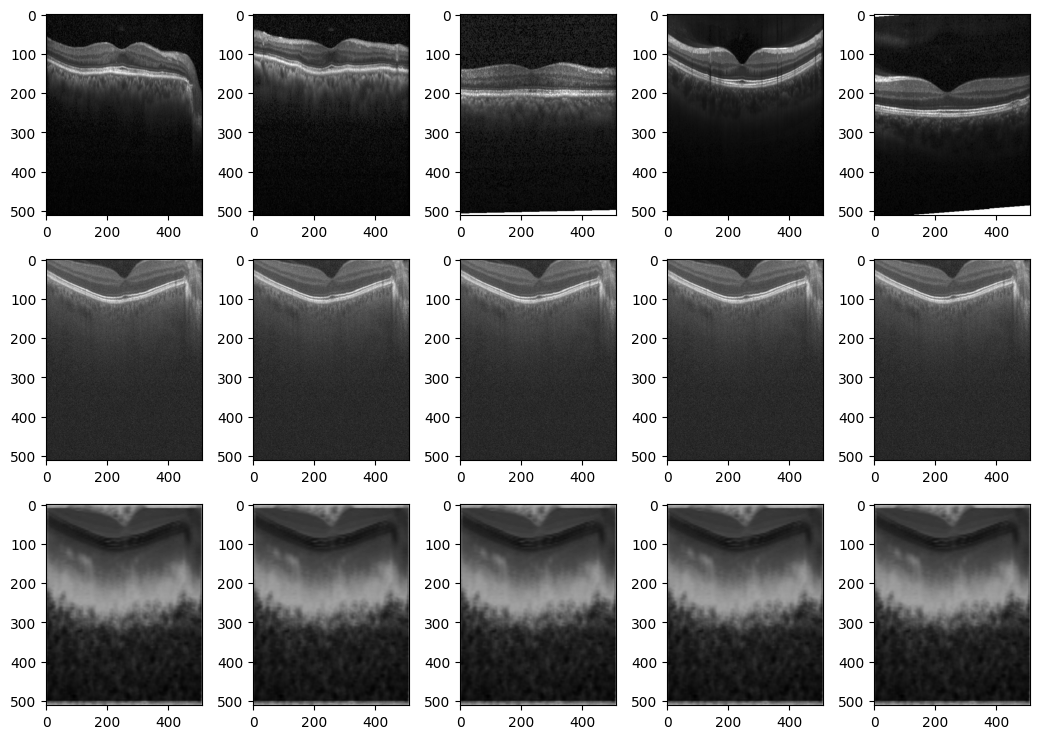

In [62]:
pred= model.predict(noised_test[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(original_test[i], (512, 512)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (512, 512)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (512, 512)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(noised_test[:5], pred[:5])

In [63]:
noised_test = noised_test.astype(np.float32)
print(original_test[0].dtype)

float32


Text(0.5, 1.0, 'Bilateral Filter')

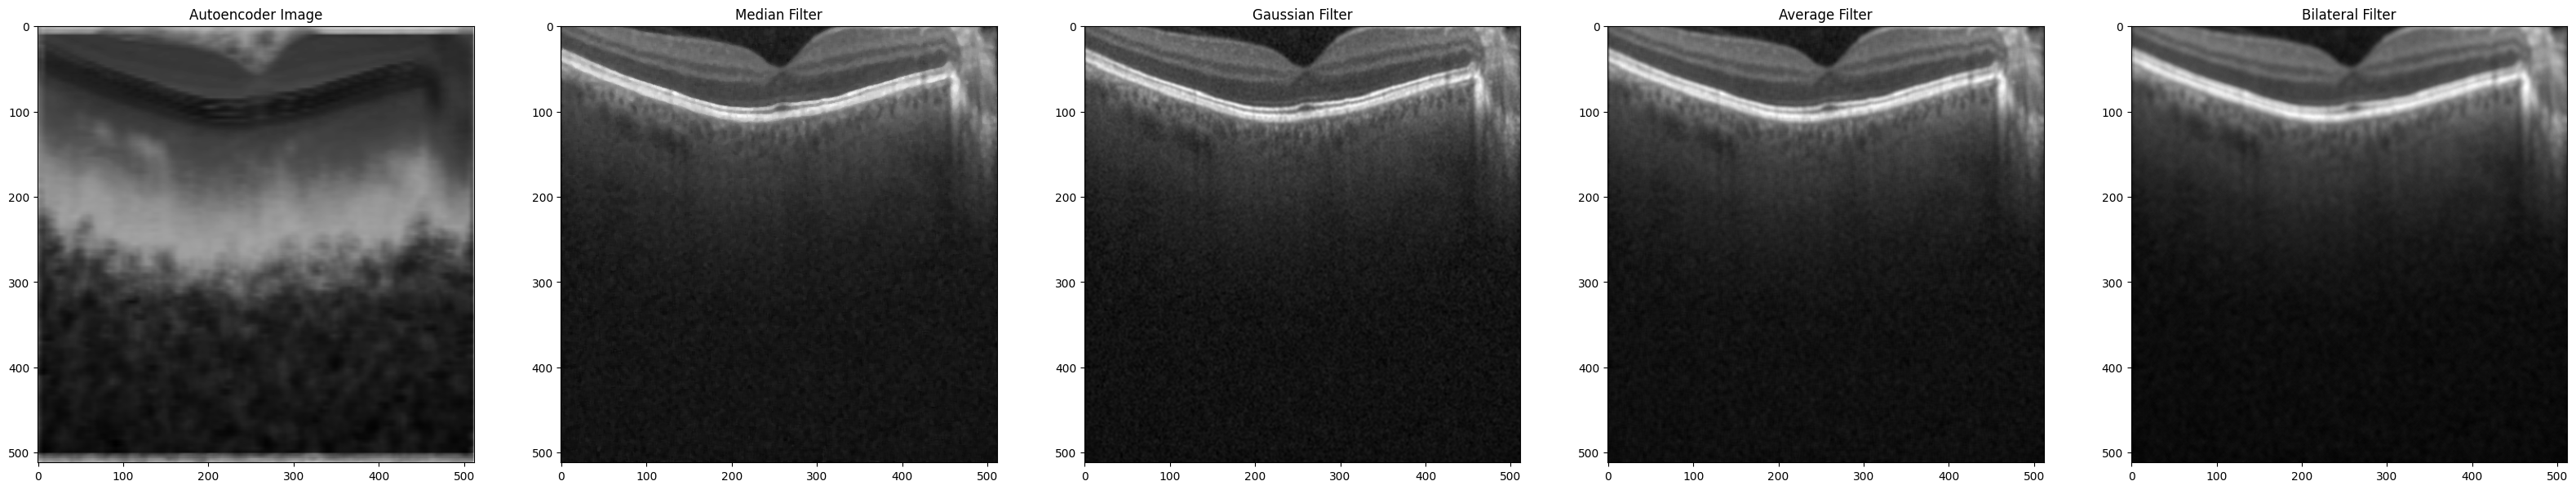

In [64]:
median_blur = cv2.medianBlur(noised_test[0], (5))
gaussian_blur=cv2.GaussianBlur(noised_test[0],(5,5),0)
average_blur=cv2.blur(noised_test[0],(5,5))
bilateral_filter=cv2.bilateralFilter(noised_test[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(512, 512), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

In [65]:
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel/sqrt(mse))
    return psnr

value1 = PSNR(original_test[0], median_blur)
value2 = PSNR(original_test[0], pred[0])
value3 = PSNR(original_test[0], gaussian_blur)
value4 = PSNR(original_test[0], average_blur)
value5 = PSNR(original_test[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 64.86343663643181 dB
Median Filter Image : 61.05376405881957 dB
Gaussian Filter Image : 61.02520620679478 dB
Average Filter Image : 61.06477901793834 dB
Bilateral Filter Image : 61.104049328160606 dB


In [66]:
def MSE (original, denoised):
    mse = np.mean((original - denoised) ** 2)
    return mse

value1 = MSE(original_test[0], median_blur)
value2 = MSE(original_test[0], pred[0])
value3 = MSE(original_test[0], gaussian_blur)
value4 = MSE(original_test[0], average_blur)
value5 = MSE(original_test[0], bilateral_filter)

print("MSE values")
print(f"Autoencoder Image : {value2} ")
print(f"Median Filter Image : {value1} ")
print(f"Gaussian Filter Image : {value3} ")
print(f"Average Filter Image : {value4} ")
print(f"Bilateral Filter Image : {value5} ")

MSE values
Autoencoder Image : 0.02121957577764988 
Median Filter Image : 0.051015712320804596 
Gaussian Filter Image : 0.051352281123399734 
Average Filter Image : 0.05088648572564125 
Bilateral Filter Image : 0.05042842775583267 


In [67]:
def SNR(original, denoised):
    signal = original
    noise = original - denoised

    # Calculate the sum of squares
    signal_power = np.sum(signal ** 2)
    noise_power = np.sum(noise ** 2)

    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

value1 = SNR(original_test[0], median_blur)
value2 = SNR(original_test[0], pred[0])
value3 = SNR(original_test[0], gaussian_blur)
value4 = SNR(original_test[0], average_blur)
value5 = SNR(original_test[0], bilateral_filter)

print("SNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")



SNR values
Autoencoder Image : 2.448278069496155 dB
Median Filter Image : -28.45409393310547 dB
Gaussian Filter Image : -28.482651710510254 dB
Average Filter Image : -28.443078994750977 dB
Bilateral Filter Image : -28.403809070587158 dB


In [68]:
def CNR(img1, img2):
    mean1, std1 = cv2.meanStdDev(img1)
    mean2, std2 = cv2.meanStdDev(img2)
    cnr_value = abs(mean1 - mean2) / (std1 + std2)
    return cnr_value[0][0]

value1 = CNR(original_test[0], median_blur)
value2 = CNR(original_test[0], pred[0])
value3 = CNR(original_test[0], gaussian_blur)
value4 = CNR(original_test[0], average_blur)
value5 = CNR(original_test[0], bilateral_filter)

print("CNR values")
print(f"Autoencoder Image : {value2} ")
print(f"Median Filter Image : {value1} ")
print(f"Gaussian Filter Image : {value3} ")
print(f"Average Filter Image : {value4} ")
print(f"Bilateral Filter Image : {value5} ")

CNR values
Autoencoder Image : 0.0032121339620070906 
Median Filter Image : 0.048455875434395966 
Gaussian Filter Image : 0.049561374042172764 
Average Filter Image : 0.04985803487883467 
Bilateral Filter Image : 0.05009308461290448 


In [69]:
from skimage.metrics import structural_similarity as ssim
def SSIM(img1, img2):
    img1 = img1.squeeze()  # Remove channel dimension for SSIM calculation
    img2 = img2.squeeze()
    ssim_value, _ = ssim(img1, img2, full=True)
    return ssim_value

value1 = SSIM(original_test[0], median_blur)
value2 = SSIM(original_test[0], pred[0])
value3 = SSIM(original_test[0], gaussian_blur)
value4 = SSIM(original_test[0], average_blur)
value5 = SSIM(original_test[0], bilateral_filter)

print("SSIM values")
print(f"Autoencoder Image : {value2} ")
print(f"Median Filter Image : {value1} ")
print(f"Gaussian Filter Image : {value3} ")
print(f"Average Filter Image : {value4} ")
print(f"Bilateral Filter Image : {value5} ")

SSIM values
Autoencoder Image : 0.5630649994969833 
Median Filter Image : 0.6027206870393941 
Gaussian Filter Image : 0.5959464758994705 
Average Filter Image : 0.6135407583118505 
Bilateral Filter Image : 0.6250889856391727 
